# Online Fraud Transaction Detection
- By **Arshia Goshtasbi**
- Github: [@Arshiagosh](https://github.com/Arshiagosh)

**Description:**\
This Jupyter Notebook presents the implementation of a decision tree algorithm for the purpose of detecting fraudulent virtual payments. The decision tree is constructed using two popular criteria: entropy and Gini index.
Fraudulent activities in virtual payments pose significant challenges to security and financial institutions. Decision trees offer a powerful method for classifying data based on feature attributes, making them well-suited for fraud detection tasks.
The notebook provides step-by-step implementation of decision tree construction using both entropy and Gini index as splitting criteria. It includes data preprocessing, model training, evaluation, and visualization of the decision tree.
By exploring this notebook, users can gain insights into how decision trees can be applied in fraud detection scenarios, and understand the differences in performance between entropy and Gini index as impurity measures.

## Importing libraries
**DT** : Implemented Decision Tree from scratch

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from DT import DecisionTree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

## Data Loading

In [29]:
# Importing the dataset
df=pd.read_csv('onlinefraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 7.6+ MB


## Data Cleaning
It's required to clean datas and prepare it for the next section.

In [30]:
# Finding howmany Nulls are there.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [31]:
# Removing any NaN
df = df.dropna()
# Removing any Duplicates
df = df.drop_duplicates()
# Counting the null values in each attribute
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

The data was clean already so that's awesome to know!

In [32]:
# Dropping useless info
df.drop(columns=['nameOrig','nameDest'],inplace=True)

In [33]:
# A simple overview
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


## Preprocessing Tools

### One-Hot Encoding for 'type' Column
One-hot encoding is used to convert categorical data into a format that can be provided to ML algorithms to improve prediction accuracy.



In [34]:
# Define a function for one-hot encoding
def one_hot_encode(df):
    df_new = df.copy()
    # Get the 'type' column
    types = df_new['type']
    # Get unique types
    unique_types = sorted(set(types))
    # Create one-hot encoded columns
    for t in unique_types:
        df_new[t] = (types == t).astype(int)
    # Drop the original 'type' column
    df_new.drop('type', axis=1, inplace=True)
    return df_new

### Discretization
To discretize continuous inputs or inputs with a large range of numerical values, we can divide the range from minimum to maximum values in the training set into equally spaced intervals and consider two extra intervals for values less than the minimum and greater than the maximum. 

In [35]:
def equal_width_binning(df, n_bins=100, column_to_ignore=None):
  """
  Bins each column in the DataFrame using equal-width intervals, excluding the specified column.

  Parameters:
    df: pandas DataFrame
      Input DataFrame to be binned.
    n_bins: int, optional (default=100)
      Number of bins to create for each column.
    column_to_ignore: str or list of str, optional
      Column(s) to exclude from binning.

  Returns:
    df_binned: pandas DataFrame
      DataFrame with each column (except the ignored one) binned using equal-width intervals.
  """

  # Handle potential None value for column_to_ignore
  if column_to_ignore is None:
    column_to_ignore = []

  # Iterate through columns excluding the ones to ignore
  for column in df.columns:
    if column not in column_to_ignore:
      min_val = df[column].min()
      max_val = df[column].max()
      width = (max_val - min_val) / n_bins
      bins = [min_val + i * width for i in range(n_bins + 1)]
      df[column] = pd.cut(df[column], bins=bins, labels=False, include_lowest=True)

  return df

### Seperating dataset based on 'type'

In [36]:
def seperate_on_type(df, type_search):
    df_new = df.loc[(df.type==type_search)]
    df_new = df_new.drop(columns=['type'])
    return df_new

### Spliting the dataset into training and test

In [37]:
def split_data(data, test_size=0.5, pos_ratio=0.5):
  """Splits data into training and testing sets with balanced fraud classes and configurable ratios.

  Args:
    data: A pandas DataFrame containing the data.
    test_size: The proportion of data to be included in the test set (default: 0.5).
    pos_ratio: The desired proportion of positive (True) class in each set (default: 0.5).

  Returns:
    A tuple containing four elements: X_train, X_test, y_train, y_test.
  """

  fraud_data = data[data['isFraud'] == True]
  non_fraud_data = data[data['isFraud'] == False]

  # Ensure data allows for desired positive ratio
  min_class_size = min(len(fraud_data), len(non_fraud_data))
  min_positive_size = int(min_class_size * pos_ratio)
  if min_positive_size > min(len(fraud_data), len(non_fraud_data)):
    raise ValueError("Data has insufficient positive class to achieve desired ratio")

  # Calculate split sizes based on test_size and desired positive ratio
  total_size = len(data)
  test_size_adjusted = test_size * total_size
  train_size = total_size - test_size_adjusted

  # Ensure integer split sizes to avoid sampling errors
  positive_train_size = int(train_size * pos_ratio)
  negative_train_size = int(train_size - positive_train_size)

  positive_test_size = int(test_size_adjusted * pos_ratio)
  negative_test_size = int(test_size_adjusted - positive_test_size)

  # Sample with replacement to achieve balanced subsets
  fraud_train = fraud_data.sample(positive_train_size, replace=True)
  if negative_train_size > 0:
      non_fraud_train = non_fraud_data.sample(negative_train_size, replace=True)
  else:
      non_fraud_train = pd.DataFrame()

  fraud_test = fraud_data.sample(positive_test_size, replace=True)
  if negative_test_size > 0:
      non_fraud_test = non_fraud_data.sample(negative_test_size, replace=True)
  else:
      non_fraud_test = pd.DataFrame()

  # Separate features (X) and labels (y)
  X_train = pd.concat([fraud_train.drop('isFraud', axis=1), non_fraud_train.drop('isFraud', axis=1)])
  y_train = pd.concat([fraud_train['isFraud'], non_fraud_train['isFraud']])

  X_test = pd.concat([fraud_test.drop('isFraud', axis=1), non_fraud_test.drop('isFraud', axis=1)])
  y_test = pd.concat([fraud_test['isFraud'], non_fraud_test['isFraud']])

  return X_train, X_test, y_train, y_test

## Evaluation Tools

### Correlation Matrix

In [38]:
def print_corr(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

### Confusion Matrix and Metrics

In [39]:
def print_eval(y_pred, y_test):
    # Assuming y_test and y_pred are your test labels and predicted labels, respectively
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()

    # Calculate additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

## Modeling

#### Approach 1
In this approach:
1) 2000 first rows of the data is used to train the dataset and 2000 after that for testing.
2) No other preprocessing is done.

In [40]:
df_ap1 = df.copy()

# Splitting the data for training and testing
X_train = df_ap1.drop(columns=['isFraud']).iloc[:2000]
y_train = df_ap1['isFraud'].iloc[:2000]

X_test = df_ap1.drop(columns=['isFraud']).iloc[2000:4000]
y_test = df_ap1['isFraud'].iloc[2000:4000]

In [41]:
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
print_eval(y_pred, y_test)

X_2 ? 0.15525613787433576
├─ Value = 8.73
│  0
├─ Value = 15.06
│  0
├─ Value = 23.31
│  0
├─ Value = 25.12
│  0
├─ Value = 27.55
│  0
├─ Value = 38.66
│  0
├─ Value = 42.0
│  0
├─ Value = 58.21
│  0
├─ Value = 79.26
│  0
├─ Value = 84.22
│  0
├─ Value = 96.32
│  0
├─ Value = 102.37
│  0
├─ Value = 106.81
│  0
├─ Value = 112.56
│  0
├─ Value = 132.42
│  0
├─ Value = 137.88
│  0
├─ Value = 141.87
│  0
├─ Value = 150.07
│  0
├─ Value = 151.2
│  0
├─ Value = 154.87
│  0
├─ Value = 181.0
│  1
├─ Value = 186.33
│  0
├─ Value = 194.4
│  0
├─ Value = 207.75
│  0
├─ Value = 226.29
│  0
├─ Value = 233.76
│  0
├─ Value = 244.09
│  0
├─ Value = 244.87
│  0
├─ Value = 261.95
│  0
├─ Value = 266.88
│  0
├─ Value = 270.78
│  0
├─ Value = 271.77
│  0
├─ Value = 272.8
│  0
├─ Value = 280.59
│  0
├─ Value = 282.42
│  1
├─ Value = 300.41
│  0
├─ Value = 320.53
│  0
├─ Value = 328.07
│  0
├─ Value = 339.82
│  0
├─ Value = 351.26
│  0
├─ Value = 353.9
│  0
├─ Value = 360.13
│  0
├─ Value = 365.0
│  0
├─ V

KeyboardInterrupt: 

##### Result
Firstly, it takes too much time and as seen in the metrics, model is saturated to 0 and it's underfitting.\
Some preprocessing methods should be used.

### Approach 2
In this approach:
1) One Hot Encoding is used for the TYPE feature.
2) Binning is used to transform the continunus features to bins. (1000 bins)
3) Dataset is splitted using the split_data function that has two parameters (test_size , pos_ratios).
    * test_size : the test size ratio
    * pos_ratio : the ratio of positive samples in both test set and training set

In [42]:
df_oneHot = one_hot_encode(df)
df_oneHot = equal_width_binning(df_oneHot, n_bins=1000,
                                column_to_ignore=['isFraud','CASH_IN',
                                                  'CASH_OUT','DEBIT',
                                                  'PAYMENT','TRANSFER'])

In [43]:
df_oneHot.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,5,4,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,1,0


In [44]:
X_train, X_test, y_train, y_test = split_data(df_oneHot, test_size=0.25, pos_ratio=0.25)

X_4 ? 0.012925229873257449
├─ Value = 0
│  X_1 ? 0.01555619614719822
│  ├─ Value = 0
│  │  X_3 ? 0.014029466556438885
│  │  ├─ Value = 0
│  │  │  X_7 ? 0.004121699941171286
│  │  │  ├─ Value = 0
│  │  │  │  X_0 ? 0.003656599963968332
│  │  │  │  ├─ Value = 0
│  │  │  │  │  X_10 ? 0.03717207538603029
│  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  X_8 ? 0.0019464088132006563
│  │  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  │  X_2 ? 0.0012014079336986616
│  │  │  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  │  │  0
│  │  │  │  │  │  │  ├─ Value = 1
│  │  │  │  │  │  │  │  0
│  │  │  │  │  │  │  └─ 
│  │  │  │  │  │  ├─ Value = 1
│  │  │  │  │  │  │  0
│  │  │  │  │  │  └─ 
│  │  │  │  │  ├─ Value = 1
│  │  │  │  │  │  1
│  │  │  │  │  └─ 
│  │  │  │  ├─ Value = 111
│  │  │  │  │  X_8 ? 0.0017979688720629328
│  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  X_2 ? 0.0003798670465335885
│  │  │  │  │  │  ├─ Value = 0
│  │  │  │  │  │  │  0
│  │  │  │  │  │  ├─ Value = 1
│  │  │  │  │  │  │  0
│  │ 

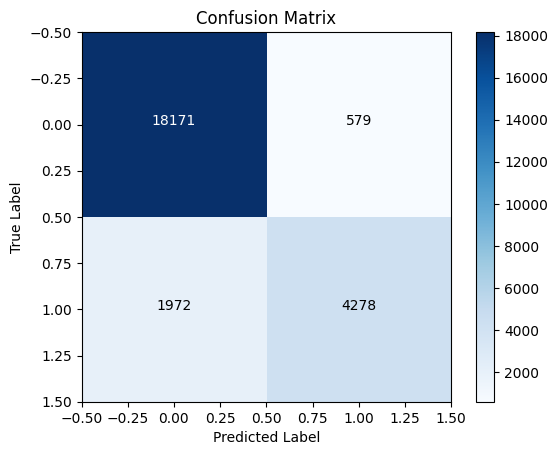

Accuracy: 0.8980
Precision: 0.8808
Recall: 0.6845
F1-Score: 0.7703


In [45]:
classifier = DecisionTree(min_samples_split=2, max_depth=10, mode='gini')
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

#### Result


### Approach 3
In this approach:
1) Each TYPE of transaction is seprated.
2) Binning is used to transform the continunus features to bins. (1000 bins)
3) Dataset is splitted using the split_data function that has two parameters (test_size , pos_ratios).
    * test_size : the test size ratio
    * pos_ratio : the ratio of positive samples in both test set and training set

X_5 ? 0.21700479234326797
├─ Value = 0
│  X_1 ? 0.4029238939832216
│  ├─ Value = 0
│  │  X_2 ? 0.2689545572345432
│  │  ├─ Value = 0
│  │  │  X_0 ? 0.3248393060231729
│  │  │  ├─ Value = 0
│  │  │  │  1
│  │  │  ├─ Value = 444
│  │  │  │  1
│  │  │  ├─ Value = 666
│  │  │  │  X_4 ? 0.1831497988820473
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 45
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 777
│  │  │  │  1
│  │  │  ├─ Value = 888
│  │  │  │  X_4 ? 0.2998428398862386
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 1
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 999
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 1
│  │  │  0
│  │  ├─ Value = 3
│  │  │  1
│  │  ├─ Value = 5
│  │  │  0
│  │  ├─ Value = 6
│  │  │  1
│  │  ├─ Value = 18
│  │  │  0
│  │  ├─ Value = 106
│  │  │  1
│  │  └─ 
│  ├─ Value = 1
│  │  X_0 ? 0.21957015015606252
│  │  ├─ Value = 0
│  │  │  X_2 ? 0.9182958340544896
│  │  │  ├─ Value = 0
│  │  │  │  0
│  │  │  ├─ Value

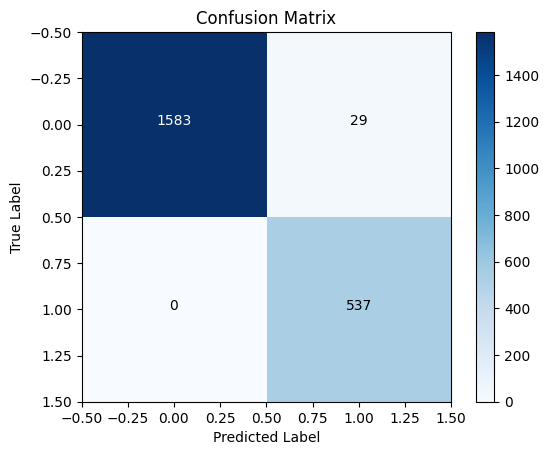

Accuracy: 0.9865
Precision: 0.9488
Recall: 1.0000
F1-Score: 0.9737


In [46]:
df_transfer = seperate_on_type(df, 'TRANSFER')
df_transfer = equal_width_binning(df_transfer, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_transfer, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.1714245399966018
├─ Value = 0
│  X_2 ? 0.8138707561629697
│  ├─ Value = 0
│  │  X_4 ? 0.4262286569981449
│  │  ├─ Value = 0
│  │  │  1
│  │  ├─ Value = 1
│  │  │  0
│  │  ├─ Value = 12
│  │  │  1
│  │  ├─ Value = 91
│  │  │  0
│  │  └─ 
│  ├─ Value = 2
│  │  0
│  ├─ Value = 5
│  │  0
│  ├─ Value = 10
│  │  0
│  ├─ Value = 20
│  │  0
│  ├─ Value = 22
│  │  0
│  ├─ Value = 24
│  │  0
│  ├─ Value = 39
│  │  0
│  ├─ Value = 41
│  │  0
│  ├─ Value = 47
│  │  0
│  ├─ Value = 50
│  │  1
│  ├─ Value = 74
│  │  0
│  ├─ Value = 84
│  │  0
│  ├─ Value = 85
│  │  0
│  ├─ Value = 89
│  │  0
│  ├─ Value = 104
│  │  0
│  ├─ Value = 111
│  │  0
│  ├─ Value = 113
│  │  0
│  ├─ Value = 114
│  │  0
│  ├─ Value = 115
│  │  0
│  ├─ Value = 117
│  │  0
│  ├─ Value = 118
│  │  0
│  ├─ Value = 123
│  │  0
│  ├─ Value = 125
│  │  0
│  ├─ Value = 147
│  │  0
│  ├─ Value = 169
│  │  0
│  ├─ Value = 183
│  │  0
│  ├─ Value = 191
│  │  0
│  ├─ Value = 194
│  │  0
│  ├─ Value = 228
│  │  0
│  ├─ Value = 229

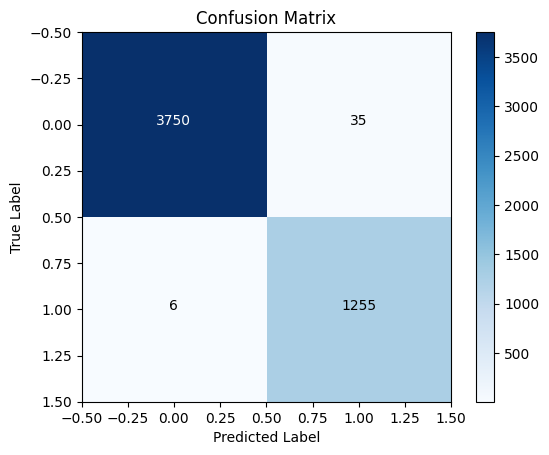

Accuracy: 0.9919
Precision: 0.9729
Recall: 0.9952
F1-Score: 0.9839


In [47]:
df_cash_in = seperate_on_type(df, 'CASH_IN')
df_cash_in = equal_width_binning(df_cash_in, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_cash_in, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_5 ? 0.07981876015655909
├─ Value = 0
│  X_1 ? 0.1412979379707806
│  ├─ Value = 0
│  │  X_2 ? 0.11553010451616041
│  │  ├─ Value = 0
│  │  │  X_4 ? 0.1673865003298194
│  │  │  ├─ Value = 0
│  │  │  │  X_0 ? 0.2157530688742434
│  │  │  │  ├─ Value = 0
│  │  │  │  │  1
│  │  │  │  ├─ Value = 222
│  │  │  │  │  0
│  │  │  │  ├─ Value = 333
│  │  │  │  │  0
│  │  │  │  ├─ Value = 666
│  │  │  │  │  1
│  │  │  │  ├─ Value = 777
│  │  │  │  │  1
│  │  │  │  ├─ Value = 888
│  │  │  │  │  0
│  │  │  │  ├─ Value = 999
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 1
│  │  │  │  0
│  │  │  ├─ Value = 2
│  │  │  │  X_0 ? 0.4335941172605444
│  │  │  │  ├─ Value = 666
│  │  │  │  │  0
│  │  │  │  ├─ Value = 888
│  │  │  │  │  1
│  │  │  │  ├─ Value = 999
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 3
│  │  │  │  0
│  │  │  ├─ Value = 4
│  │  │  │  0
│  │  │  ├─ Value = 5
│  │  │  │  0
│  │  │  ├─ Value = 6
│  │  │  │  0
│  │  │  ├─ Value = 7
│  │  │  │  0
│  │  │  ├─ Value = 8
│  │  

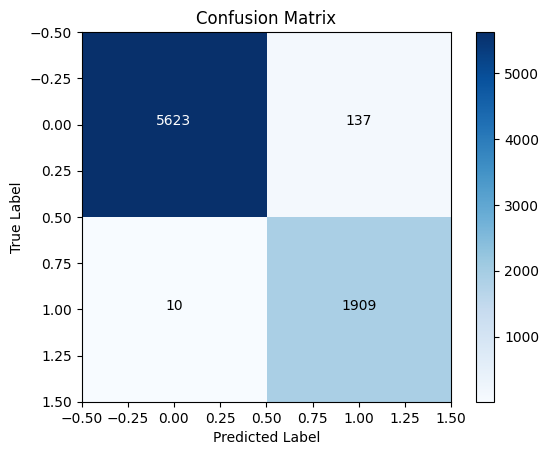

Accuracy: 0.9809
Precision: 0.9330
Recall: 0.9948
F1-Score: 0.9629


In [48]:
df_cash_out = seperate_on_type(df, 'CASH_OUT')
df_cash_out = equal_width_binning(df_cash_out, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_cash_out, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.16570694700786415
├─ Value = 0
│  X_2 ? 0.7985214400621254
│  ├─ Value = 0
│  │  X_5 ? 0.4022651249629339
│  │  ├─ Value = 0
│  │  │  X_0 ? 0.2974722489192896
│  │  │  ├─ Value = 777
│  │  │  │  1
│  │  │  ├─ Value = 888
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 2
│  │  │  0
│  │  ├─ Value = 6
│  │  │  1
│  │  ├─ Value = 97
│  │  │  0
│  │  └─ 
│  ├─ Value = 2
│  │  0
│  ├─ Value = 3
│  │  0
│  ├─ Value = 9
│  │  0
│  ├─ Value = 10
│  │  0
│  ├─ Value = 13
│  │  0
│  ├─ Value = 20
│  │  0
│  ├─ Value = 38
│  │  0
│  ├─ Value = 44
│  │  0
│  ├─ Value = 46
│  │  0
│  ├─ Value = 50
│  │  1
│  ├─ Value = 65
│  │  0
│  ├─ Value = 84
│  │  0
│  ├─ Value = 99
│  │  0
│  ├─ Value = 103
│  │  0
│  ├─ Value = 113
│  │  0
│  ├─ Value = 117
│  │  0
│  ├─ Value = 118
│  │  0
│  ├─ Value = 145
│  │  0
│  ├─ Value = 160
│  │  0
│  ├─ Value = 169
│  │  0
│  ├─ Value = 183
│  │  0
│  ├─ Value = 189
│  │  0
│  ├─ Value = 210
│  │  0
│  ├─ Value = 219
│  │  0
│  ├─ Value = 220
│  │  0
│  ├─ Val

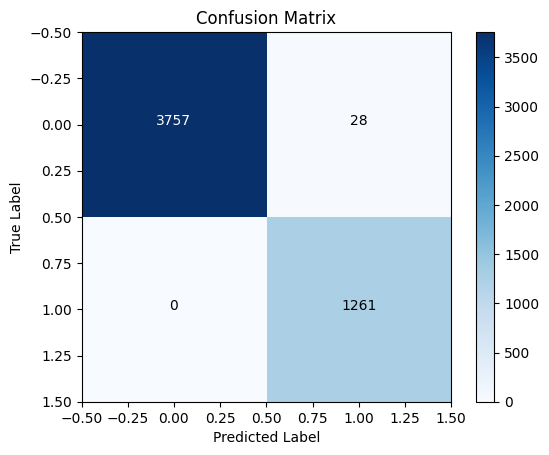

Accuracy: 0.9945
Precision: 0.9783
Recall: 1.0000
F1-Score: 0.9890


In [49]:
df_payment = seperate_on_type(df, 'CASH_IN')
df_payment = equal_width_binning(df_payment, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_payment, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]
print_eval(y_pred, y_test)

X_1 ? 0.1728414190221632
├─ Value = 0
│  X_2 ? 0.6775483037723729
│  ├─ Value = 0
│  │  X_4 ? 0.38321953095889916
│  │  ├─ Value = 0
│  │  │  X_5 ? 0.31168988698645606
│  │  │  ├─ Value = 0
│  │  │  │  X_0 ? 0.25767880510333147
│  │  │  │  ├─ Value = 777
│  │  │  │  │  1
│  │  │  │  ├─ Value = 888
│  │  │  │  │  0
│  │  │  │  └─ 
│  │  │  ├─ Value = 2
│  │  │  │  0
│  │  │  └─ 
│  │  ├─ Value = 1
│  │  │  0
│  │  ├─ Value = 2
│  │  │  0
│  │  ├─ Value = 12
│  │  │  1
│  │  ├─ Value = 44
│  │  │  0
│  │  └─ 
│  ├─ Value = 2
│  │  0
│  ├─ Value = 3
│  │  0
│  ├─ Value = 5
│  │  0
│  ├─ Value = 10
│  │  0
│  ├─ Value = 13
│  │  0
│  ├─ Value = 22
│  │  0
│  ├─ Value = 38
│  │  0
│  ├─ Value = 41
│  │  0
│  ├─ Value = 44
│  │  0
│  ├─ Value = 47
│  │  0
│  ├─ Value = 50
│  │  1
│  ├─ Value = 72
│  │  0
│  ├─ Value = 84
│  │  0
│  ├─ Value = 85
│  │  0
│  ├─ Value = 89
│  │  0
│  ├─ Value = 90
│  │  0
│  ├─ Value = 99
│  │  0
│  ├─ Value = 104
│  │  0
│  ├─ Value = 117
│  │  0
│  ├─ Value =

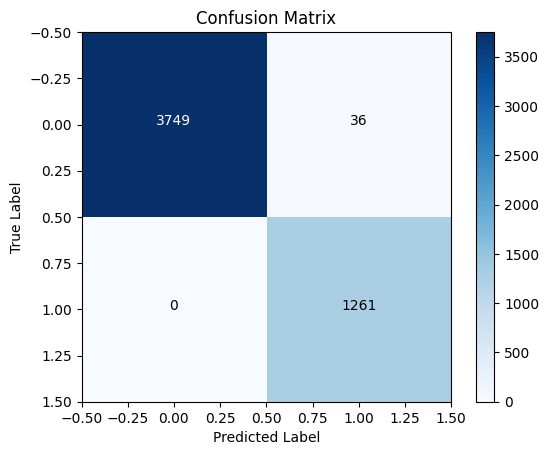

Accuracy: 0.9929
Precision: 0.9722
Recall: 1.0000
F1-Score: 0.9859


In [50]:
df_debit = seperate_on_type(df, 'CASH_IN')
df_debit = equal_width_binning(df_debit, n_bins=1000, column_to_ignore=['isFraud'])
X_train, X_test, y_train, y_test = split_data(df_debit, test_size=0.25, pos_ratio=0.25)
classifier = DecisionTree(min_samples_split=2, max_depth=10)
classifier.fit(X_train.values,y_train.values.reshape(-1,1))
classifier.print_tree()
y_pred = classifier.predict(X_test.values)
y_pred = [0 if x is None else x for x in y_pred]

print_eval(y_pred, y_test)

#### Result

### Skit-learn and XGBoost Models
In this part, models are used with One Hot Encoding.

In [ ]:
X_train, X_test, y_train, y_test = split_data(df_oneHot, test_size=0.25, pos_ratio=0.25)

#### Decision Tree -> Gini Index

[[18065   685]
 [ 1961  4289]]


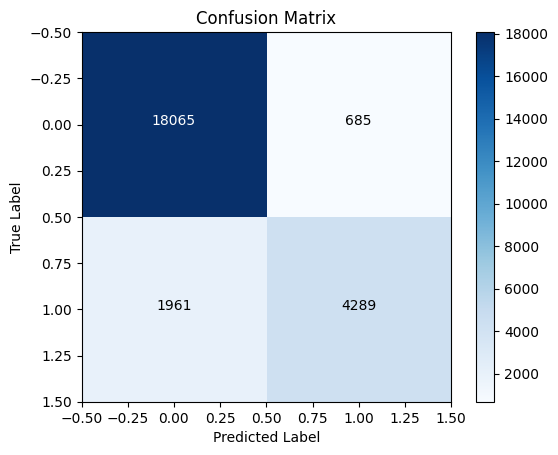

Accuracy: 0.8942
Precision: 0.8623
Recall: 0.6862
F1-Score: 0.7643


In [52]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
classifier_dt.fit(X_train, y_train)
y_pred = classifier_dt.predict(X_test)
print_eval(y_pred, y_test)

#### Decision Tree -> Entropy

[[18136   614]
 [ 1961  4289]]


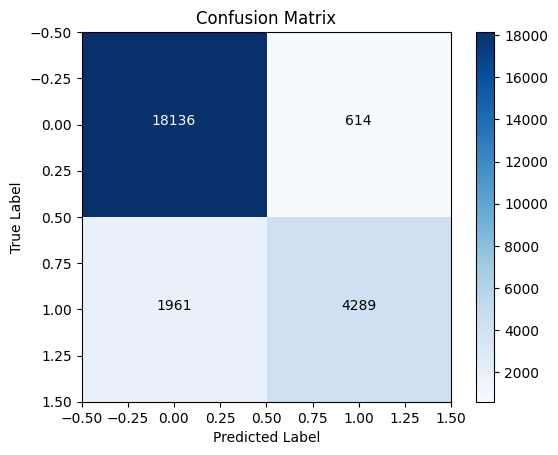

Accuracy: 0.8970
Precision: 0.8748
Recall: 0.6862
F1-Score: 0.7691


In [53]:
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
classifier_dt.fit(X_train, y_train)
y_pred = classifier_dt.predict(X_test)
print_eval(y_pred, y_test)

#### Logistic Regression

c:\Users\Arshia\Desktop\ArshiaGoshtasbi_DT_Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[18743     7]
 [ 6205    45]]


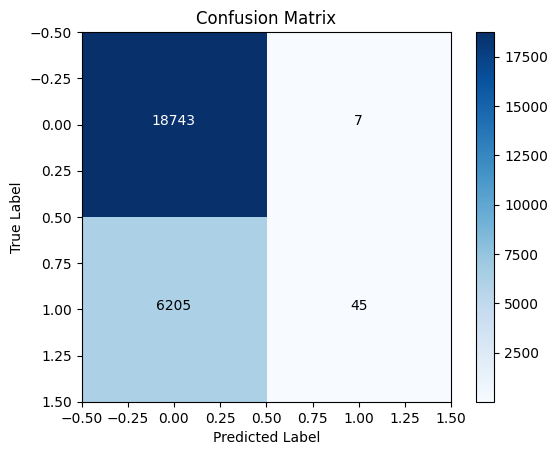

Accuracy: 0.7515
Precision: 0.8654
Recall: 0.0072
F1-Score: 0.0143


In [54]:
from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression(random_state = 42)
classifier_logistic.fit(X_train, y_train)
y_pred = classifier_logistic.predict(X_test)
print_eval(y_pred, y_test)

#### Random Forest

[[18743     7]
 [ 6205    45]]


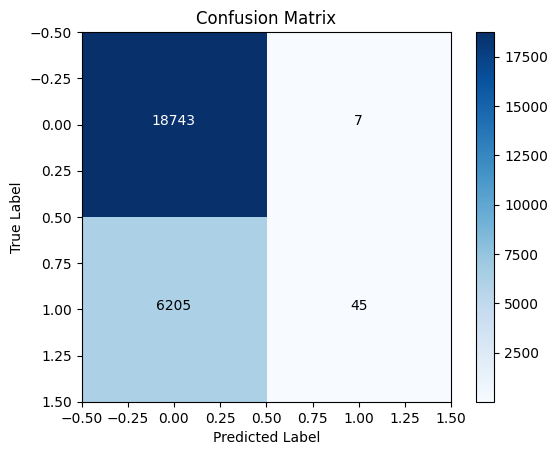

Accuracy: 0.7515
Precision: 0.8654
Recall: 0.0072
F1-Score: 0.0143


In [55]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier_rf.fit(X_train, y_train)
y_pred = classifier_logistic.predict(X_test)
print_eval(y_pred, y_test)

#### XGBoost

[[18535   215]
 [ 4142  2108]]


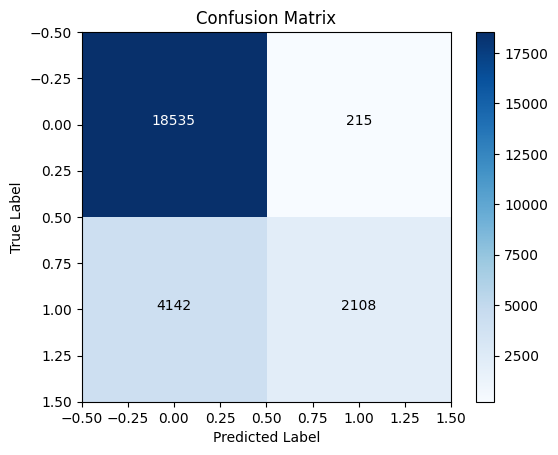

Accuracy: 0.8257
Precision: 0.9074
Recall: 0.3373
F1-Score: 0.4918


In [56]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)
y_pred = classifier_xgb.predict(X_test)
print_eval(y_pred, y_test)

#### Result
As seen, even the powerful libraries such as skit-learn can't perform well without seprating the dataset based on their TYPE.